Part A: 
In this part first we import our file then we do some preprocessing that is needed to refine our data set.




In [14]:
import pandas as pd
from sklearn.impute import SimpleImputer
titanic_df = pd.read_csv('train.csv')
# Drop irrelevant columns
titanic_df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

# Handle missing values
titanic_df['Age'].fillna(titanic_df['Age'].median(), inplace=True)
titanic_df['Cabin'].fillna('Unknown', inplace=True)
titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode()[0], inplace=True)

# Convert categorical variables to numerical
titanic_df['Sex'] = titanic_df['Sex'].map({'male': 0, 'female': 1})
titanic_df['Cabin'] = titanic_df['Cabin'].str[0]
titanic_df['Cabin'] = titanic_df['Cabin'].map(
    {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7, 'Unknown': 8})
titanic_df['Embarked'] = titanic_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
col_list = titanic_df.columns[2:]
imputer = SimpleImputer(strategy="mean")
titanic_df[col_list] = imputer.fit_transform(titanic_df[col_list])
# Split the data into features and target
X = titanic_df.drop('Survived', axis=1)
y = titanic_df['Survived']
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    float64
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    float64
 5   Parch     891 non-null    float64
 6   Fare      891 non-null    float64
 7   Cabin     891 non-null    float64
 8   Embarked  891 non-null    float64
dtypes: float64(7), int64(2)
memory usage: 62.8 KB


**Part B:** In this part we split the dataset.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Part C:** In this part we try to use hyperparameter tuning in order to optimize the performance of the decision tree model

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the decision tree model
dt = DecisionTreeClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(dt, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}


**Part D:** In this part we train the decision tree.

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the decision tree model with the best hyperparameters
dt = DecisionTreeClassifier(
    max_depth=5, min_samples_leaf=1, min_samples_split=2, max_features='sqrt')

# Train the decision tree model on the training data
dt.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dt.predict(X_test)

# Calculate the performance metrics on the test data
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

Accuracy: 0.78
Precision: 0.77
Recall: 0.68
F1-score: 0.72


**Part E:** In this part we try to visualize the decision tree using Graphviz.

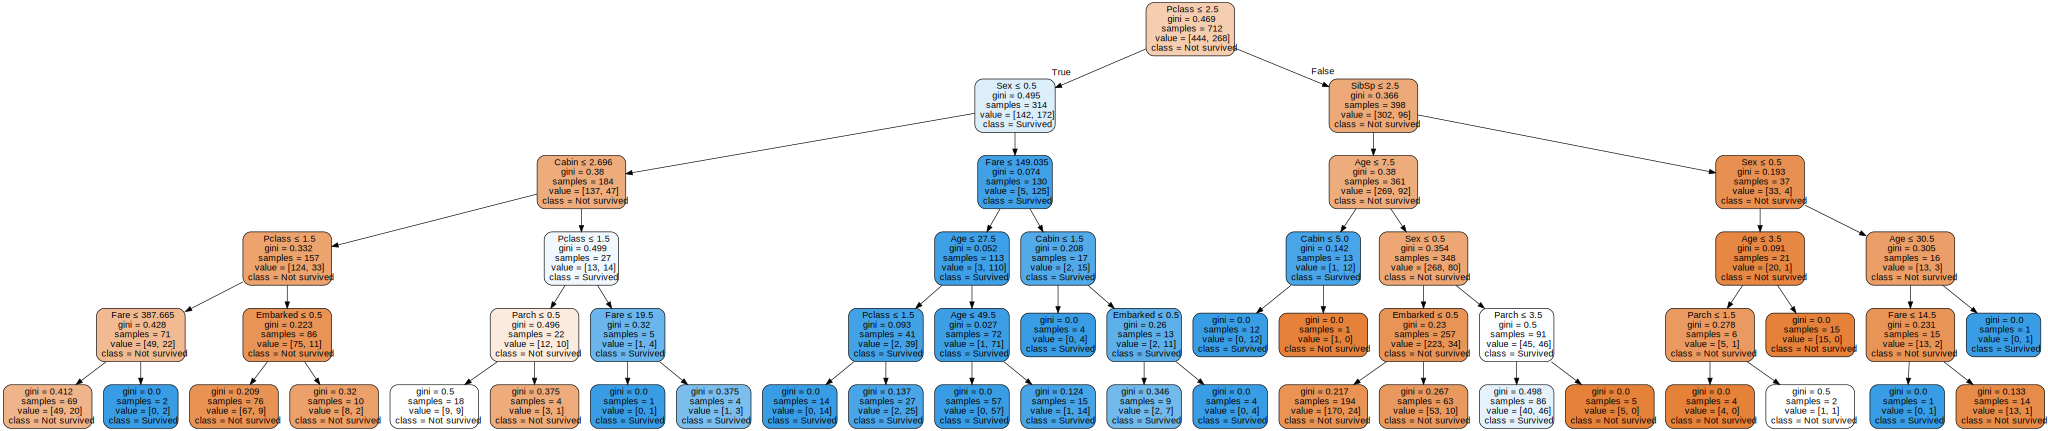

In [19]:
from sklearn.tree import export_graphviz
import graphviz

# Export the decision tree to DOT format
dot_data = export_graphviz(dt, out_file=None,
                           feature_names=X_train.columns,
                           class_names=['Not survived', 'Survived'],
                           filled=True, rounded=True,
                           special_characters=True)

# Visualize the decision tree with Graphviz
graphviz.Source(dot_data)

**Part F&G:** In this part we perform pruning on the decision tree model and compare it with the original model

Pruned Decision Tree:
Accuracy: 0.80
Precision: 0.83
Recall: 0.65
F1-score: 0.73


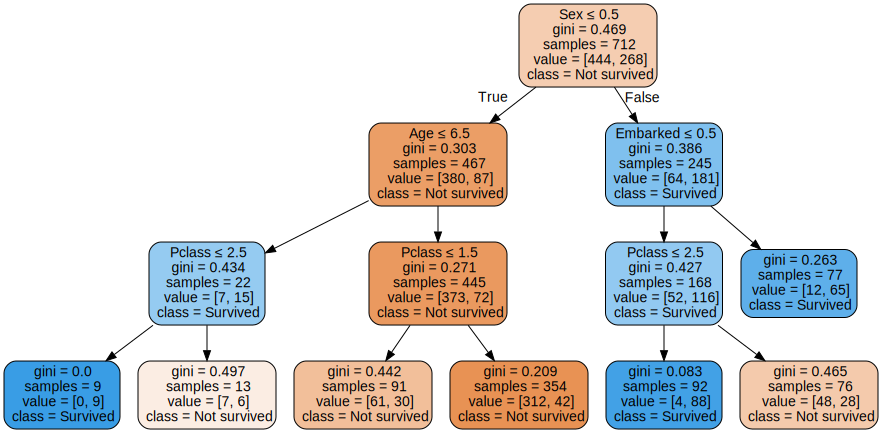

In [22]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Define the decision tree model with the best hyperparameters
dt = DecisionTreeClassifier(
    max_depth=5, min_samples_leaf=1, min_samples_split=2, max_features='sqrt')

# Train the decision tree model on the training data
dt.fit(X_train, y_train)

# Determine the optimal alpha value for cost complexity pruning
path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Train decision trees with different alpha values and evaluate their performance
dts = []
for ccp_alpha in ccp_alphas:
    dt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=1,
                                min_samples_split=2, max_features='sqrt', ccp_alpha=ccp_alpha)
    dt.fit(X_train, y_train)
    dts.append(dt)

# Evaluate the performance of the decision trees with different alpha values on the validation data
train_scores = [dt.score(X_train, y_train) for dt in dts]
test_scores = [dt.score(X_test, y_test) for dt in dts]

# Find the optimal alpha value that maximizes the test score
optimal_alpha = ccp_alphas[test_scores.index(max(test_scores))]

# Train the decision tree with the optimal alpha value on the full training data
dt_pruned = DecisionTreeClassifier(max_depth=5, min_samples_leaf=1,
                                   min_samples_split=2, max_features='sqrt', ccp_alpha=optimal_alpha)
dt_pruned.fit(X_train, y_train)

# Report the performance metrics of the pruned decision tree on the test data
y_pred_pruned = dt_pruned.predict(X_test)
accuracy_pruned = accuracy_score(y_test, y_pred_pruned)
precision_pruned = precision_score(y_test, y_pred_pruned)
recall_pruned = recall_score(y_test, y_pred_pruned)
f1_pruned = f1_score(y_test, y_pred_pruned)
print("Pruned Decision Tree:")
print("Accuracy: {:.2f}".format(accuracy_pruned))
print("Precision: {:.2f}".format(precision_pruned))
print("Recall: {:.2f}".format(recall_pruned))
print("F1-score: {:.2f}".format(f1_pruned))

# Visualize the pruned decision tree
dot_data_pruned = export_graphviz(dt_pruned, out_file=None,
                                  feature_names=X_train.columns,
                                  class_names=['Not survived', 'Survived'],
                                  filled=True, rounded=True,
                                  special_characters=True)
graph_pruned = graphviz.Source(dot_data_pruned)
graph_pruned.render('pruned_titanic_decision_tree')